# Fase 1: Clasificación del movimiento

**Descripción**\
Copia de Fase1

**Entrada**
* ``medidasPerRepetition.csv``: archivo en formato CSV que contiene cálculos estadísticos sobre los ángulos por repetición de cada sujeto. Este es el archivo de salida de *leer_dataset.ipynb*.

**Salida**
* ``modelo_fase1_copy.sav``: archivo que guarda el pipeline completo de clasificación entrenado

******

In [1]:
# ---------- Importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# Scikit-learn (ML en python)
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
## Seleccion de variables
from sklearn.feature_selection import SelectKBest

#Pipeline
from imblearn.pipeline import Pipeline

# Guardar modelos
import joblib

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.drop(['CorrectLabel'], axis=1,
             inplace=True)
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,GestureName,RepetitionNumber,Duration,KneeAngleLeft_standardDeviation,WristAngleLeft_standardDeviation,KneeAngleRight_standardDeviation,ShoulderAngleRight_standardDeviation,WristAngleRight_standardDeviation,...,WristAngleRight_Kurtosis,ElbowAngleRight_Kurtosis,AnkleAngleLeft_Kurtosis,LeftArmAngle_Kurtosis,RightArmAngle_Kurtosis,ArmsTogetherAngle_Kurtosis,HipAngleRight_Kurtosis,AnkleAngleRight_Kurtosis,HipAngleLeft_Kurtosis,ShoulderAngleLeft_Kurtosis
0,102,0,EFL,1,74,0.4832901252293081,1.3775399963780737,0.30295783311531727,3.294713554484951,10.26101242229342,...,0.375606810920206,-1.4904572038164694,-0.9218459378889565,-0.9889825587727601,0.22147301566722177,-0.8511018898740983,-1.2130443787023806,15.481423750569686,0.1950860066202451,-1.2511436779592484
1,102,0,EFL,2,64,0.5585933064433087,1.6271894060456007,0.3243613585322476,4.742959999419659,14.450470086179894,...,1.1543998957163382,-1.431169382708514,-1.415922318356331,-1.2938450639789785,-1.4860333958071466,-1.4196823310401139,0.1663793296511078,30.5994648202742,-0.7888113108681654,-0.472467253988782
2,102,0,EFL,3,58,0.6824351203616622,1.6989747606490668,0.5425238690861536,5.070927804652568,19.336369323958806,...,9.59080204890984,-1.4481284878299678,-1.2031165908034858,-1.2447151128330012,-0.7913285454951731,-1.5629680711446194,-1.3046791681113268,2.3465174536000597,-0.9158241443474404,-0.80871088359656
3,102,0,EFL,4,60,0.6142143078481765,2.016339624917005,0.3526484943010881,4.030705303230586,25.598713023913547,...,4.1336237058292,-1.5858806918810486,-1.515334441103624,-1.5331879897259844,0.2021513530164274,-1.6903677661810008,0.005323712651228885,7.285594611894105,-1.1852260550732128,-1.177012012109949
4,102,0,EFL,5,63,0.48977124638261627,1.7008586220937247,0.2594906980411227,5.0214031977910025,17.18236360360904,...,5.640903309376775,-1.4608887020665993,-0.5172894066010225,-1.2588672287903098,0.8374033797172151,-1.7197444051478152,-0.4846351691232118,15.865257246460724,-0.5924323757251706,-0.6891877979451944


****

## 1. Preprocesado

**1.1 Codificar variables**

In [3]:
# ------Preparar el dataset-------
df = df.drop(['GestureName'], axis=1)

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')
df.head()

,SubjectID,GestureLabel,RepetitionNumber,Duration,KneeAngleLeft_standardDeviation,WristAngleLeft_standardDeviation,KneeAngleRight_standardDeviation,ShoulderAngleRight_standardDeviation,WristAngleRight_standardDeviation,ElbowAngleRight_standardDeviation,...,WristAngleRight_Kurtosis,ElbowAngleRight_Kurtosis,AnkleAngleLeft_Kurtosis,LeftArmAngle_Kurtosis,RightArmAngle_Kurtosis,ArmsTogetherAngle_Kurtosis,HipAngleRight_Kurtosis,AnkleAngleRight_Kurtosis,HipAngleLeft_Kurtosis,ShoulderAngleLeft_Kurtosis
0,102,0,1,74,0.483290,1.377540,0.302958,3.294714,10.261012,53.294387,...,0.375607,-1.490457,-0.921846,-0.988983,0.221473,-0.851102,-1.213044,15.481424,0.195086,-1.251144
1,102,0,2,64,0.558593,1.627189,0.324361,4.742960,14.450470,49.408774,...,1.154400,-1.431169,-1.415922,-1.293845,-1.486033,-1.419682,0.166379,30.599465,-0.788811,-0.472467
2,102,0,3,58,0.682435,1.698975,0.542524,5.070928,19.336369,47.972135,...,9.590802,-1.448128,-1.203117,-1.244715,-0.791329,-1.562968,-1.304679,2.346517,-0.915824,-0.808711
3,102,0,4,60,0.614214,2.016340,0.352648,4.030705,25.598713,49.082401,...,4.133624,-1.585881,-1.515334,-1.533188,0.202151,-1.690368,0.005324,7.285595,-1.185226,-1.177012
4,102,0,5,63,0.489771,1.700859,0.259491,5.021403,17.182364,49.404534,...,5.640903,-1.460889,-0.517289,-1.258867,0.837403,-1.719744,-0.484635,15.865257,-0.592432,-0.689188


**1.2 Dividir el dataset**

In [4]:
# ---- Dividir en test y train -----------
# Selecciona los datos de prueba (varios sujetos)
test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
            (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==302)] 

# Selecciona los datos de entrenamiento excluyendo los mismos sujetos
train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=302)]

# Caclular porcentajes
n_total = len(df)
print(f'Entrenamiento {(len(train_df)*100)/n_total}%. Prueba {(len(test_df)*100)/n_total}%')

# ------- Dividir en target y variables ---------
train_X = train_df.drop(['GestureLabel'], axis=1)
train_y=pd.DataFrame(train_df['GestureLabel']) 
test_X= test_df.drop(['GestureLabel'], axis=1) 
test_y =pd.DataFrame(test_df['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()

Entrenamiento 76.71232876712328%. Prueba 23.28767123287671%


*****

## 2. Pipeline

**2.1 Malla de hiperparámetros**

In [5]:
#------------- Malla de hiperparametros ---------------
param_grid = [
    {
        'feature_selection__k': list(range(5, 60)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [6, 7, 8],
        'classifier__weights': ('uniform', 'distance'),
        'classifier__leaf_size': (3, 4, 5, 6, 8),
        'classifier__p': (1,2),
        'classifier__metric': ('minkowski', 'chebyshev')
    },
    {
        'feature_selection__k': list(range(5, 60)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [None, 40, 50, 60],
        'classifier__min_samples_split': [2, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5, 7],
        'classifier__max_features': [None, 'sqrt', 'log2']
    },
    {
        'feature_selection__k': list(range(5, 60)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'feature_selection__k': list(range(5, 60)),
        'classifier': [SVC()],
        'classifier__C': [0.1, 0.2, 0.3],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [2, 3],
        'classifier__coef0': [0.0, 0.1, 0.2]
    },
    {
        'feature_selection__k': list(range(5, 60)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [300, 400, 500],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__max_depth': [None, 50, 60],
        'classifier__min_samples_split': [2, 3, 4],
        'classifier__min_samples_leaf': [1, 2, 5, 6],
    },
    {
        
        'feature_selection__k': list(range(5, 60)),
        'classifier': [MLPClassifier()],
        'classifier__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,), (100, 50), (50, 50),], 
        'classifier__activation': ['relu', 'tanh', 'logistic'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
        'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
    }
]

**2.2 Pipeline e hiperparametrización**

In [6]:
logo = LeaveOneGroupOut()
subject_ids = train_X['SubjectID'] # para los grupos
pipeline = Pipeline([
                     ('feature_selection', SelectKBest(k=50)),
                     ('classifier', KNeighborsClassifier(n_neighbors=2))
                    ])
random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=15,
                            scoring='f1_weighted', random_state=42)
random.fit(train_X, train_y, groups=subject_ids)

best_modelo = random.best_estimator_
print(best_modelo)

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('feature_selection', SelectKBest(k=45)),
                ('classifier',
                 RandomForestClassifier(max_depth=60, min_samples_leaf=5,
                                        min_samples_split=4,
                                        n_estimators=300))])


**2.3 Evaluación del pipeline**

In [7]:
f1_score_train = best_modelo.score(train_X, train_y)
print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
print("Informe de clasificación (conjunto de prueba):")
prediction = best_modelo.predict(test_X)
print(classification_report(test_y, prediction)) 

F1-score del conjunto de entrenamiento: 0.9763655462184874
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           0       0.84      0.98      0.90        52
           1       1.00      0.67      0.80        70
           2       0.80      0.93      0.86        84
           3       0.50      0.82      0.62        57
           4       0.96      0.57      0.71        83
           5       0.86      0.84      0.85        43
           6       0.84      0.89      0.86        46
           7       1.00      0.57      0.72        60
           8       0.78      0.99      0.87        83

    accuracy                           0.80       578
   macro avg       0.84      0.81      0.80       578
weighted avg       0.85      0.80      0.80       578



* **Curva de apendizaje**

<Figure size 600x400 with 0 Axes>

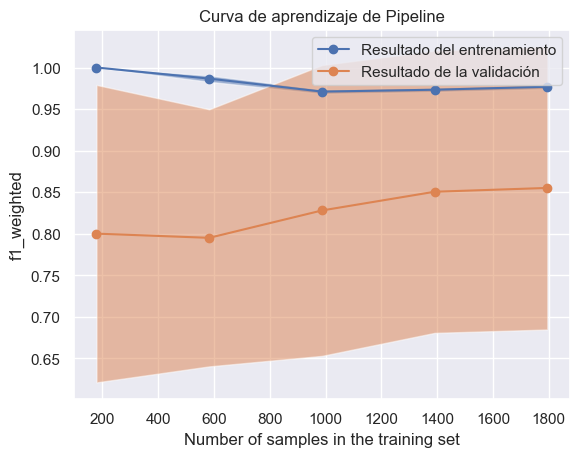

In [8]:
plt.figure(figsize=(6,4))
LearningCurveDisplay.from_estimator(best_modelo, 
                                    X=train_X,
                                    y=train_y,
                                    groups=subject_ids,
                                    cv=logo,
                                    score_type="both",
                                    n_jobs=4,
                                    line_kw={"marker": "o"},
                                    std_display_style="fill_between",
                                    score_name="f1_weighted"
                                )
    
plt.legend(["Resultado del entrenamiento", "Resultado de la validación"])
plt.title(f"Curva de aprendizaje de {random.estimator.__class__.__name__}")
plt.show()

* **Matriz de confusión**

Text(47.25, 0.5, 'True labels')

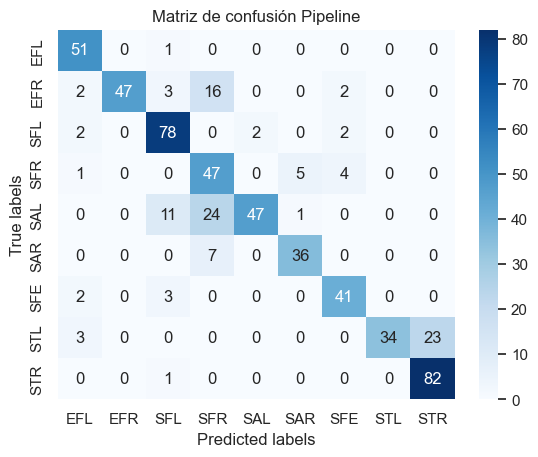

In [9]:
cm = confusion_matrix(test_y, prediction)
cm_df = pd.DataFrame(cm,
                    index = ['EFL','EFR','SFL', 'SFR', 'SAL',
                            'SAR', 'SFE', 'STL', 'STR'], 
                    columns = ['EFL','EFR','SFL', 'SFR', 'SAL',
                            'SAR', 'SFE', 'STL', 'STR'])
ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
ax.set_title(f'Matriz de confusión {best_modelo.__class__.__name__}')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

**2.3 Guardar el pipeline**

In [ ]:
# ------ Guardar el pipeline entrenado --------
filename = '../Resultados/modelo_fase1_copy.sav'
joblib.dump(best_modelo, filename)